In [7]:
import pandas as pd
import numpy as np
import torch
from transformers import DebertaTokenizer, DebertaModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Balance dataset to randomly clone rows to match target classes
def balance_dataset(df):
    df_classA = df[df['Quality'] == 1]
    df_classB = df[df['Quality'] == 0]
    if len(df_classA) < len(df_classB):
        minority_class, majority_class = df_classA, df_classB
    else:
        minority_class, majority_class = df_classB, df_classA
    if len(minority_class) < len(majority_class):
        minority_class = resample(minority_class, n_samples=len(majority_class), replace=True, random_state=0)
    df_balanced = pd.concat([majority_class, minority_class]).sample(frac=1, random_state=0).reset_index(drop=True)
    return df_balanced

# Return cosine similarity value
def calculate_cosine_similarity(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

# Convert text to vector with passed tokenizer model
def encode_sentence(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().tolist()

# Create dataframe containing cosine similarity of texts
def calculate_features(df, tokenizer, model):
    cosine_sim_L = []
    for _, row in df.iterrows():
        vec1 = encode_sentence(row['#1 String'], tokenizer, model)
        vec2 = encode_sentence(row['#2 String'], tokenizer, model)
        cosine_sim = calculate_cosine_similarity(vec1, vec2)
        cosine_sim_L.append(cosine_sim)
    df_features = pd.DataFrame({'Cosine Similarity': cosine_sim_L, 'Quality': df['Quality']})
    return df_features

# Declare X, Y, training and test sets
def split_data(df_features):
    y_data = df_features["Quality"]
    X_data = df_features.drop(["Quality"], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=0)
    print(X_train.shape, ': Training data size')
    print(X_test.shape, ': Test data size')
    return X_train, X_test, y_train, y_test

# Scale data and make prediction
def adjust_predict_test(X_train, X_test, y_train, y_test, classifier):
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    classifier.fit(scaled_X_train, y_train)
    pred_y = classifier.predict(scaled_X_test)
    return pred_y, scaled_X_test

# Plot confusion matrix
def plot_confusion_matrix(y_test, pred_y):
    cm = confusion_matrix(y_test, pred_y)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
# Plot ROC curve
def plot_roc_curve(y_test, y_scores):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc_score = roc_auc_score(y_test, y_scores)
    plt.plot(fpr, tpr, color='orange', label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
# Plot precision recall curve
def plot_precision_recall_curve(y_test, y_scores):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)
    plt.step(recall, precision, where='post', color='orange', alpha=0.5, label=f'Average Precision = {avg_precision:.2f}')
    plt.fill_between(recall, precision, step='post', alpha=0.5, color='blue')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    plt.show()

# === Main Driver ===

if __name__ == "__main__":
    # Load the dataset and remove rows with missing values necessary
    df_train = pd.read_csv('MSR_Paraphrase_train.csv')
    df_test = pd.read_csv('MSR_Paraphrase_test.csv')
    df = pd.concat([df_train, df_test], ignore_index=True)
    df.dropna(subset=['Quality', '#1 String', '#2 String'], inplace=True)
    df = balance_dataset(df)

    # Declare and encode with language model
    print("Loading DeBERTa dataset...")
    model_name = "microsoft/deberta-base"
    tokenizer = DebertaTokenizer.from_pretrained(model_name)
    model = DebertaModel.from_pretrained(model_name)
    df_features = calculate_features(df, tokenizer, model)

    # Split data into X and Y sets
    X_train, X_test, y_train, y_test = split_data(df_features)

    from sklearn.ensemble import RandomForestClassifier
    
    # Train with Random Forest and assess
    classifier = RandomForestClassifier(random_state=0)
    pred_y, scaled_X_test = adjust_predict_test(X_train, X_test, y_train, y_test, classifier)

Loading DeBERTa dataset...
(6190, 1) : Training data size
(1548, 1) : Test data size


In [8]:
    from sklearn.ensemble import RandomForestClassifier
    
    # Train with Random Forest and assess
    classifier = RandomForestClassifier(random_state=0)
    pred_y, scaled_X_test = adjust_predict_test(X_train, X_test, y_train, y_test, classifier)

    print("\nAccuracy:")
    print(accuracy_score(y_test, pred_y))
    
    print("\nClassification Report:")
    print(classification_report(y_test, pred_y))


Accuracy:
0.8236434108527132

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       754
           1       0.90      0.74      0.81       794

    accuracy                           0.82      1548
   macro avg       0.83      0.83      0.82      1548
weighted avg       0.83      0.82      0.82      1548




Confusion Matrix:


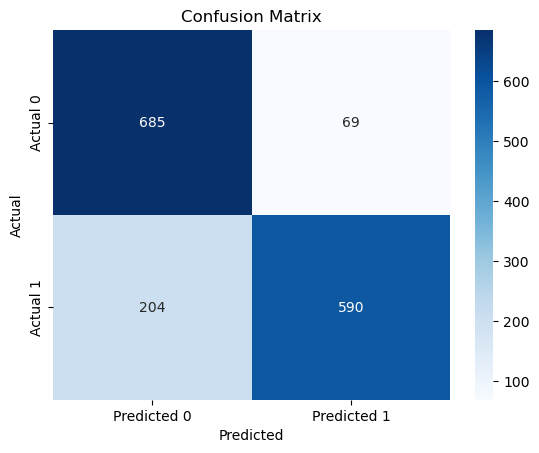


ROC Curve and AUC Score:


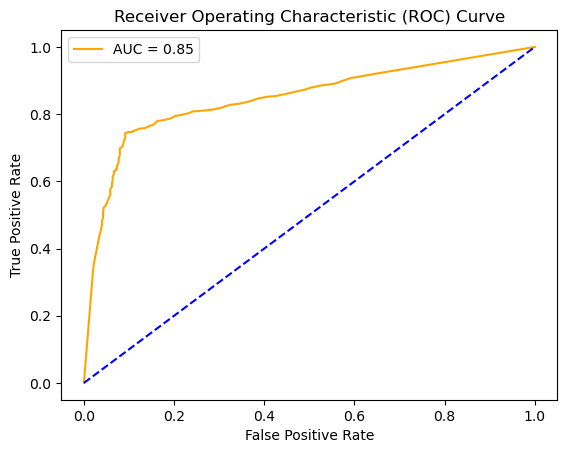

In [9]:
    # Display confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_test, pred_y)
    
    # Display ROC curve
    y_prob = classifier.predict_proba(scaled_X_test)[:, 1]
    print("\nROC Curve and AUC Score:")
    plot_roc_curve(y_test, y_prob)


Precision Recall Curve:


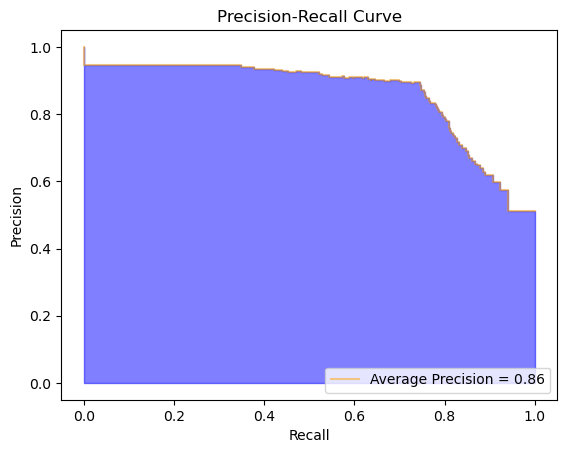

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Display precision recall curve
print("\nPrecision Recall Curve:")
plot_precision_recall_curve(y_test, y_prob)